# **Starbucks Stock Price Forecasting**
> 🤔 We are going to train a LSTM and CNN model on our Starbucks Data that I got on this link - https://finance.yahoo.com/quote/SBUX/history?period1=1061856000&period2=1693008000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
df = pd.read_csv('SBUX.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-08-26,6.7500,6.7900,6.6250,6.7750,5.358759,10353200
1,2003-08-27,6.7550,6.8125,6.7125,6.7800,5.362714,6354400
2,2003-08-28,6.8250,6.9450,6.7575,6.9100,5.465537,11426400
3,2003-08-29,7.0125,7.1325,6.9275,7.0975,5.613843,17445600
4,2003-09-02,7.0225,7.2125,7.0150,7.1875,5.685032,14224400


## Exploring and vsualizing the Data

In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5030,2023-08-21,97.320000,97.570000,96.160004,96.459999,96.459999,3753200
5031,2023-08-22,96.489998,96.739998,95.599998,96.070000,96.070000,3640500
5032,2023-08-23,96.419998,96.559998,94.010002,95.180000,95.180000,9704500
5033,2023-08-24,94.750000,95.629997,93.709999,94.830002,94.830002,7824500
5034,2023-08-25,95.540001,95.959999,94.510002,95.480003,95.480003,5358800


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5035 entries, 0 to 5034
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5035 non-null   object 
 1   Open       5035 non-null   float64
 2   High       5035 non-null   float64
 3   Low        5035 non-null   float64
 4   Close      5035 non-null   float64
 5   Adj Close  5035 non-null   float64
 6   Volume     5035 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 275.5+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.shape

(5035, 7)

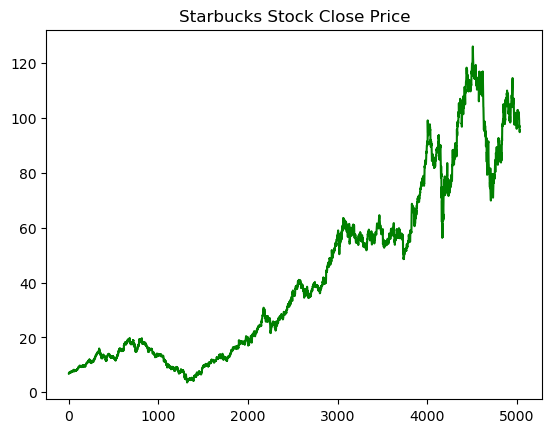

In [8]:
# plot the close price of the stock
df['Close'].plot(color='green', title='Starbucks Stock Close Price')
plt.show();

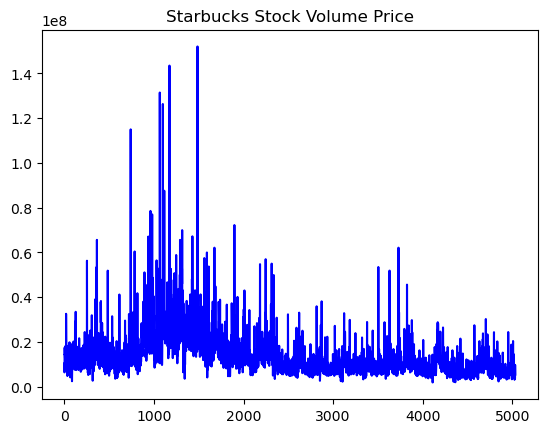

In [9]:
# plot the close price of the stock
df['Volume'].plot(color='blue', title='Starbucks Stock Volume Price')
plt.show();

In [10]:
X = df['Close'].to_numpy()
X

array([ 6.775   ,  6.78    ,  6.91    , ..., 95.18    , 94.830002,
       95.480003])

In [11]:
X.shape

(5035,)

## MinMax Scaling the Data

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1))

In [13]:
X_scaled

array([[0.02604613],
       [0.02608696],
       [0.0271484 ],
       ...,
       [0.74786692],
       [0.74500921],
       [0.75031643]])

In [14]:
X_scaled.shape

(5035, 1)

## Splitting into Training and testing

In [15]:
def make_train_test_split(train_size:float, data):
    train_index = int(len(data) * train_size)
    train = data[:train_index]
    test = data[train_index:]
    return train, test

In [16]:
train_data, test_data = make_train_test_split(data=X_scaled, train_size=0.9)

In [17]:
train_data.shape, test_data.shape

((4531, 1), (504, 1))

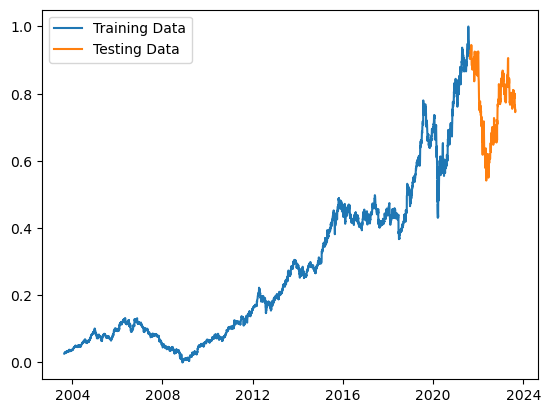

In [18]:
plt.plot(df['Date'][:4531], train_data, label='Training Data')
plt.plot(df['Date'][4531:], test_data, label='Testing Data')
plt.legend()

## Windowing our dataset

In [19]:
def make_windowed_datasets(data, window_size, horizon_size):
    X = []
    y = []
    for i in range(len(data)-(window_size + horizon_size)):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

In [20]:
X_train, y_train = make_windowed_datasets(train_data, window_size=7, horizon_size=1)
X_test, y_test = make_windowed_datasets(test_data, window_size=7, horizon_size=1)

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4523, 7), (4523,), (496, 7), (496,))

In [22]:
X_train[0]

array([0.02604613, 0.02608696, 0.0271484 , 0.02867932, 0.02941417,
       0.02984283, 0.03031231])

In [23]:
print(f'Input Day 1 : \n {scaler.inverse_transform(X_train[0].reshape(-1, 1))}')
print(f'Output Day 1: \n {scaler.inverse_transform(y_train[0].reshape(-1, 1))}')

Input Day 1 : 
 [[6.775 ]
 [6.78  ]
 [6.91  ]
 [7.0975]
 [7.1875]
 [7.24  ]
 [7.2975]]
Output Day 1: 
 [[7.2025]]


In [24]:
# reshaping our X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [25]:
X_train.shape, X_test.shape

((4523, 1, 7), (496, 1, 7))

## Modelling Experiments
* Simple LSTM model
* Complex LSTM model
* CNN model

In [26]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [28]:
model1 = Sequential()
model1.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(1, 7)))
model1.add(LSTM(64, activation='relu'))

model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='linear'))

# compiling our model
model1.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mse']
)

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 57,729
Trainable params: 57,729
Non-trainable params: 0
_________________________________________________________________


In [30]:
history1 = model1.fit(X_train, y_train,
                     epochs=100,
                     validation_data=(X_test, y_test),
                     callbacks=[create_model_checkpoint(model_name='Simple_LSTM_model')])

Epoch 1/100
129/142 [==========================>...] - ETA: 0s - loss: 0.0227 - mse: 0.0227

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 7s 30ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 8.7586e-04 - val_mse: 8.7586e-04
Epoch 2/100
129/142 [==========================>...] - ETA: 0s - loss: 1.3603e-04 - mse: 1.3603e-04

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 25ms/step - loss: 1.3474e-04 - mse: 1.3474e-04 - val_loss: 6.1406e-04 - val_mse: 6.1406e-04
Epoch 3/100
141/142 [============================>.] - ETA: 0s - loss: 1.0410e-04 - mse: 1.0410e-04

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 26ms/step - loss: 1.0417e-04 - mse: 1.0417e-04 - val_loss: 5.2777e-04 - val_mse: 5.2777e-04
Epoch 4/100
131/142 [==========================>...] - ETA: 0s - loss: 1.0510e-04 - mse: 1.0510e-04

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 25ms/step - loss: 1.0379e-04 - mse: 1.0379e-04 - val_loss: 5.1127e-04 - val_mse: 5.1127e-04
Epoch 5/100
142/142 [==============================] - 1s 4ms/step - loss: 1.0299e-04 - mse: 1.0299e-04 - val_loss: 6.4615e-04 - val_mse: 6.4615e-04
Epoch 6/100
127/142 [=========================>....] - ETA: 0s - loss: 9.5549e-05 - mse: 9.5549e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 26ms/step - loss: 9.3355e-05 - mse: 9.3355e-05 - val_loss: 4.8767e-04 - val_mse: 4.8767e-04
Epoch 7/100
142/142 [==============================] - 1s 4ms/step - loss: 9.4107e-05 - mse: 9.4107e-05 - val_loss: 5.4309e-04 - val_mse: 5.4309e-04
Epoch 8/100
142/142 [==============================] - 1s 4ms/step - loss: 9.8004e-05 - mse: 9.8004e-05 - val_loss: 5.3470e-04 - val_mse: 5.3470e-04
Epoch 9/100
142/142 [==============================] - 1s 4ms/step - loss: 9.5641e-05 - mse: 9.5641e-05 - val_loss: 5.8359e-04 - val_mse: 5.8359e-04
Epoch 10/100
140/142 [============================>.] - ETA: 0s - loss: 8.7145e-05 - mse: 8.7145e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 24ms/step - loss: 8.7173e-05 - mse: 8.7173e-05 - val_loss: 4.0045e-04 - val_mse: 4.0045e-04
Epoch 11/100
142/142 [==============================] - 1s 4ms/step - loss: 8.7691e-05 - mse: 8.7691e-05 - val_loss: 4.4014e-04 - val_mse: 4.4014e-04
Epoch 12/100
127/142 [=========================>....] - ETA: 0s - loss: 8.8671e-05 - mse: 8.8671e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 25ms/step - loss: 8.8637e-05 - mse: 8.8637e-05 - val_loss: 3.9571e-04 - val_mse: 3.9571e-04
Epoch 13/100
142/142 [==============================] - 1s 4ms/step - loss: 8.8343e-05 - mse: 8.8343e-05 - val_loss: 4.5876e-04 - val_mse: 4.5876e-04
Epoch 14/100
142/142 [==============================] - 1s 4ms/step - loss: 7.6886e-05 - mse: 7.6886e-05 - val_loss: 8.2979e-04 - val_mse: 8.2979e-04
Epoch 15/100
142/142 [==============================] - 1s 4ms/step - loss: 1.0130e-04 - mse: 1.0130e-04 - val_loss: 5.0229e-04 - val_mse: 5.0229e-04
Epoch 16/100
141/142 [============================>.] - ETA: 0s - loss: 7.5623e-05 - mse: 7.5623e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 24ms/step - loss: 7.5461e-05 - mse: 7.5461e-05 - val_loss: 3.3709e-04 - val_mse: 3.3709e-04
Epoch 17/100
142/142 [==============================] - 1s 4ms/step - loss: 7.2909e-05 - mse: 7.2909e-05 - val_loss: 4.3247e-04 - val_mse: 4.3247e-04
Epoch 18/100
142/142 [==============================] - 1s 4ms/step - loss: 8.7845e-05 - mse: 8.7845e-05 - val_loss: 4.2648e-04 - val_mse: 4.2648e-04
Epoch 19/100
142/142 [==============================] - 1s 4ms/step - loss: 6.7510e-05 - mse: 6.7510e-05 - val_loss: 3.4607e-04 - val_mse: 3.4607e-04
Epoch 20/100
139/142 [============================>.] - ETA: 0s - loss: 6.1362e-05 - mse: 6.1362e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 27ms/step - loss: 6.1859e-05 - mse: 6.1859e-05 - val_loss: 2.9040e-04 - val_mse: 2.9040e-04
Epoch 21/100
142/142 [==============================] - 1s 4ms/step - loss: 7.3713e-05 - mse: 7.3713e-05 - val_loss: 3.6137e-04 - val_mse: 3.6137e-04
Epoch 22/100
142/142 [==============================] - 1s 4ms/step - loss: 8.4462e-05 - mse: 8.4462e-05 - val_loss: 2.9728e-04 - val_mse: 2.9728e-04
Epoch 23/100
142/142 [==============================] - ETA: 0s - loss: 8.0394e-05 - mse: 8.0394e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 24ms/step - loss: 8.0394e-05 - mse: 8.0394e-05 - val_loss: 2.7845e-04 - val_mse: 2.7845e-04
Epoch 24/100
142/142 [==============================] - 1s 4ms/step - loss: 7.9471e-05 - mse: 7.9471e-05 - val_loss: 3.4924e-04 - val_mse: 3.4924e-04
Epoch 25/100
142/142 [==============================] - 1s 4ms/step - loss: 6.9981e-05 - mse: 6.9981e-05 - val_loss: 4.7577e-04 - val_mse: 4.7577e-04
Epoch 26/100
139/142 [============================>.] - ETA: 0s - loss: 6.2875e-05 - mse: 6.2875e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 24ms/step - loss: 6.3484e-05 - mse: 6.3484e-05 - val_loss: 2.7722e-04 - val_mse: 2.7722e-04
Epoch 27/100
142/142 [==============================] - 1s 4ms/step - loss: 5.8489e-05 - mse: 5.8489e-05 - val_loss: 2.8233e-04 - val_mse: 2.8233e-04
Epoch 28/100
142/142 [==============================] - 1s 4ms/step - loss: 6.6674e-05 - mse: 6.6674e-05 - val_loss: 4.0558e-04 - val_mse: 4.0558e-04
Epoch 29/100
137/142 [===========================>..] - ETA: 0s - loss: 7.1151e-05 - mse: 7.1151e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 26ms/step - loss: 7.0025e-05 - mse: 7.0025e-05 - val_loss: 2.6345e-04 - val_mse: 2.6345e-04
Epoch 30/100
142/142 [==============================] - 1s 4ms/step - loss: 5.9341e-05 - mse: 5.9341e-05 - val_loss: 5.4293e-04 - val_mse: 5.4293e-04
Epoch 31/100
142/142 [==============================] - 1s 4ms/step - loss: 7.6658e-05 - mse: 7.6658e-05 - val_loss: 3.5687e-04 - val_mse: 3.5687e-04
Epoch 32/100
141/142 [============================>.] - ETA: 0s - loss: 6.5986e-05 - mse: 6.5986e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 24ms/step - loss: 6.5874e-05 - mse: 6.5874e-05 - val_loss: 2.5750e-04 - val_mse: 2.5750e-04
Epoch 33/100
142/142 [==============================] - 1s 4ms/step - loss: 6.0393e-05 - mse: 6.0393e-05 - val_loss: 3.1050e-04 - val_mse: 3.1050e-04
Epoch 34/100
142/142 [==============================] - 1s 4ms/step - loss: 7.6993e-05 - mse: 7.6993e-05 - val_loss: 2.5921e-04 - val_mse: 2.5921e-04
Epoch 35/100
142/142 [==============================] - 1s 4ms/step - loss: 7.3650e-05 - mse: 7.3650e-05 - val_loss: 4.1827e-04 - val_mse: 4.1827e-04
Epoch 36/100
142/142 [==============================] - 1s 4ms/step - loss: 6.2446e-05 - mse: 6.2446e-05 - val_loss: 3.6163e-04 - val_mse: 3.6163e-04
Epoch 37/100
142/142 [==============================] - 1s 4ms/step - loss: 7.8164e-05 - mse: 7.8164e-05 - val_loss: 2.7164e-04 - val_mse: 2.7164e-04
Epoch 38/100
142/142 [==============================] - 1s 4ms/step - loss: 6.5959e-05 - mse: 6.5959e-05 - val_l

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 25ms/step - loss: 5.9631e-05 - mse: 5.9631e-05 - val_loss: 2.4878e-04 - val_mse: 2.4878e-04
Epoch 44/100
142/142 [==============================] - 1s 4ms/step - loss: 6.7087e-05 - mse: 6.7087e-05 - val_loss: 3.8773e-04 - val_mse: 3.8773e-04
Epoch 45/100
142/142 [==============================] - 1s 4ms/step - loss: 5.7854e-05 - mse: 5.7854e-05 - val_loss: 3.3336e-04 - val_mse: 3.3336e-04
Epoch 46/100
142/142 [==============================] - 1s 4ms/step - loss: 5.9819e-05 - mse: 5.9819e-05 - val_loss: 2.7025e-04 - val_mse: 2.7025e-04
Epoch 47/100
142/142 [==============================] - 1s 4ms/step - loss: 5.9150e-05 - mse: 5.9150e-05 - val_loss: 3.1780e-04 - val_mse: 3.1780e-04
Epoch 48/100
142/142 [==============================] - 1s 4ms/step - loss: 6.6488e-05 - mse: 6.6488e-05 - val_loss: 7.8503e-04 - val_mse: 7.8503e-04
Epoch 49/100
142/142 [==============================] - 1s 4ms/step - loss: 9.0878e-05 - mse: 9.0878e-05 - val_l

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 25ms/step - loss: 5.3368e-05 - mse: 5.3368e-05 - val_loss: 2.3838e-04 - val_mse: 2.3838e-04
Epoch 57/100
142/142 [==============================] - 1s 4ms/step - loss: 5.9458e-05 - mse: 5.9458e-05 - val_loss: 2.8721e-04 - val_mse: 2.8721e-04
Epoch 58/100
142/142 [==============================] - 1s 4ms/step - loss: 5.8692e-05 - mse: 5.8692e-05 - val_loss: 3.8564e-04 - val_mse: 3.8564e-04
Epoch 59/100
142/142 [==============================] - 1s 4ms/step - loss: 6.3451e-05 - mse: 6.3451e-05 - val_loss: 7.2445e-04 - val_mse: 7.2445e-04
Epoch 60/100
142/142 [==============================] - 1s 4ms/step - loss: 5.8749e-05 - mse: 5.8749e-05 - val_loss: 4.0848e-04 - val_mse: 4.0848e-04
Epoch 61/100
142/142 [==============================] - 1s 4ms/step - loss: 7.3684e-05 - mse: 7.3684e-05 - val_loss: 2.8030e-04 - val_mse: 2.8030e-04
Epoch 62/100
141/142 [============================>.] - ETA: 0s - loss: 5.2414e-05 - mse: 5.2414e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 26ms/step - loss: 5.2342e-05 - mse: 5.2342e-05 - val_loss: 2.3637e-04 - val_mse: 2.3637e-04
Epoch 63/100
140/142 [============================>.] - ETA: 0s - loss: 6.3255e-05 - mse: 6.3255e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 27ms/step - loss: 6.3540e-05 - mse: 6.3540e-05 - val_loss: 2.3525e-04 - val_mse: 2.3525e-04
Epoch 64/100
141/142 [============================>.] - ETA: 0s - loss: 5.7196e-05 - mse: 5.7196e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 24ms/step - loss: 5.7261e-05 - mse: 5.7261e-05 - val_loss: 2.3377e-04 - val_mse: 2.3377e-04
Epoch 65/100
142/142 [==============================] - 1s 4ms/step - loss: 6.3542e-05 - mse: 6.3542e-05 - val_loss: 2.6424e-04 - val_mse: 2.6424e-04
Epoch 66/100
142/142 [==============================] - 1s 4ms/step - loss: 5.3660e-05 - mse: 5.3660e-05 - val_loss: 5.6734e-04 - val_mse: 5.6734e-04
Epoch 67/100
142/142 [==============================] - 1s 4ms/step - loss: 6.5001e-05 - mse: 6.5001e-05 - val_loss: 2.4472e-04 - val_mse: 2.4472e-04
Epoch 68/100
142/142 [==============================] - 1s 4ms/step - loss: 5.2739e-05 - mse: 5.2739e-05 - val_loss: 2.5613e-04 - val_mse: 2.5613e-04
Epoch 69/100
142/142 [==============================] - 1s 4ms/step - loss: 5.2332e-05 - mse: 5.2332e-05 - val_loss: 2.7091e-04 - val_mse: 2.7091e-04
Epoch 70/100
142/142 [==============================] - 1s 4ms/step - loss: 6.1996e-05 - mse: 6.1996e-05 - val_l

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 25ms/step - loss: 5.9184e-05 - mse: 5.9184e-05 - val_loss: 2.3201e-04 - val_mse: 2.3201e-04
Epoch 73/100
142/142 [==============================] - 1s 4ms/step - loss: 7.5443e-05 - mse: 7.5443e-05 - val_loss: 3.8440e-04 - val_mse: 3.8440e-04
Epoch 74/100
142/142 [==============================] - 1s 4ms/step - loss: 5.3910e-05 - mse: 5.3910e-05 - val_loss: 3.0173e-04 - val_mse: 3.0173e-04
Epoch 75/100
142/142 [==============================] - 1s 4ms/step - loss: 5.2780e-05 - mse: 5.2780e-05 - val_loss: 2.5369e-04 - val_mse: 2.5369e-04
Epoch 76/100
142/142 [==============================] - 1s 4ms/step - loss: 5.4158e-05 - mse: 5.4158e-05 - val_loss: 3.9415e-04 - val_mse: 3.9415e-04
Epoch 77/100
142/142 [==============================] - ETA: 0s - loss: 5.3901e-05 - mse: 5.3901e-05

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 4s 26ms/step - loss: 5.3901e-05 - mse: 5.3901e-05 - val_loss: 2.2922e-04 - val_mse: 2.2922e-04
Epoch 78/100
142/142 [==============================] - 1s 4ms/step - loss: 5.1432e-05 - mse: 5.1432e-05 - val_loss: 3.1644e-04 - val_mse: 3.1644e-04
Epoch 79/100
142/142 [==============================] - 1s 4ms/step - loss: 5.3335e-05 - mse: 5.3335e-05 - val_loss: 2.4413e-04 - val_mse: 2.4413e-04
Epoch 80/100
142/142 [==============================] - 1s 4ms/step - loss: 6.9321e-05 - mse: 6.9321e-05 - val_loss: 5.8156e-04 - val_mse: 5.8156e-04
Epoch 81/100
142/142 [==============================] - 1s 4ms/step - loss: 5.6235e-05 - mse: 5.6235e-05 - val_loss: 2.3493e-04 - val_mse: 2.3493e-04
Epoch 82/100
142/142 [==============================] - 1s 4ms/step - loss: 5.8016e-05 - mse: 5.8016e-05 - val_loss: 2.6107e-04 - val_mse: 2.6107e-04
Epoch 83/100
142/142 [==============================] - 1s 4ms/step - loss: 5.4934e-05 - mse: 5.4934e-05 - val_l

INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


INFO:tensorflow:Assets written to: model_experiments\Simple_LSTM_model\assets


142/142 [==============================] - 3s 24ms/step - loss: 5.6710e-05 - mse: 5.6710e-05 - val_loss: 2.2439e-04 - val_mse: 2.2439e-04
Epoch 86/100
142/142 [==============================] - 1s 4ms/step - loss: 5.5405e-05 - mse: 5.5405e-05 - val_loss: 3.6836e-04 - val_mse: 3.6836e-04
Epoch 87/100
142/142 [==============================] - 1s 4ms/step - loss: 6.4655e-05 - mse: 6.4655e-05 - val_loss: 2.4224e-04 - val_mse: 2.4224e-04
Epoch 88/100
142/142 [==============================] - 1s 4ms/step - loss: 5.2965e-05 - mse: 5.2965e-05 - val_loss: 3.8517e-04 - val_mse: 3.8517e-04
Epoch 89/100
142/142 [==============================] - 1s 4ms/step - loss: 5.6579e-05 - mse: 5.6579e-05 - val_loss: 2.2569e-04 - val_mse: 2.2569e-04
Epoch 90/100
142/142 [==============================] - 1s 4ms/step - loss: 5.0779e-05 - mse: 5.0779e-05 - val_loss: 2.2861e-04 - val_mse: 2.2861e-04
Epoch 91/100
142/142 [==============================] - 1s 4ms/step - loss: 4.9668e-05 - mse: 4.9668e-05 - val_l

## Evaluating a model

In [31]:
model1.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 2.6427e-04 - mse: 2.6427e-04


[0.00026427331613376737, 0.00026427331613376737]

In [32]:
# lets get the best performing stored model in the modelling experiments folder
model1 = tf.keras.models.load_model('model_experiments/Simple_LSTM_model')
model1.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 2.2439e-04 - mse: 2.2439e-04


[0.00022438986343331635, 0.00022438986343331635]

In [33]:
model1.evaluate(X_train, y_train)

142/142 [==============================] - 0s 2ms/step - loss: 4.2429e-05 - mse: 4.2429e-05


[4.242910290486179e-05, 4.242910290486179e-05]

In [34]:
y_preds = tf.squeeze(model1.predict(X_test))
y_preds[:5]

16/16 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.9294243 , 0.92734885, 0.9186686 , 0.9279083 , 0.9355616 ],
      dtype=float32)>

In [35]:
from sklearn.metrics import r2_score

# Make sure float32 (for metric calculations)
y_test = tf.cast(y_test, dtype=tf.float32)
y_preds = tf.cast(y_preds, dtype=tf.float32)

# Calculate various metrics
mae = tf.keras.metrics.mean_absolute_error(y_test, y_preds)
mse = tf.keras.metrics.mean_squared_error(y_test, y_preds) # puts and emphasis on outliers (all errors get squared)
rmse = tf.sqrt(mse)
mape = tf.keras.metrics.mean_absolute_percentage_error(y_test, y_preds)
r2 = r2_score(y_test, y_preds)

print(f"""
MAE : {mae.numpy()}
MSE : {mse.numpy()}
RMSE : {rmse.numpy()}
MAPE : {mape.numpy()}
R2 Score : {r2}""")


MAE : 0.01109505258500576
MSE : 0.00022438986343331635
RMSE : 0.014979648403823376
MAPE : 1.5059828758239746
R2 Score : 0.9775888246821973


<Axes: >

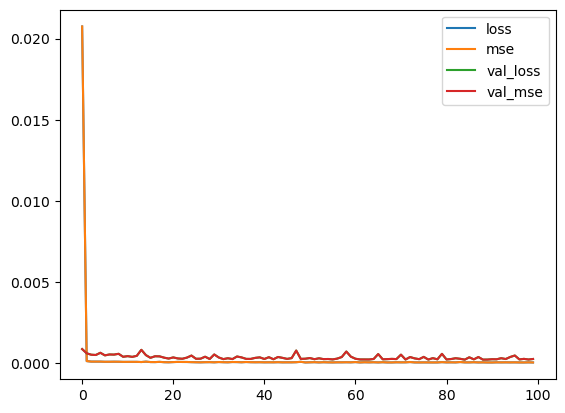

In [36]:
pd.DataFrame(history1.history).plot()

## Visualzing our predictions on Test Data

Text(0.5, 1.0, 'Test Data vs. Predictions')

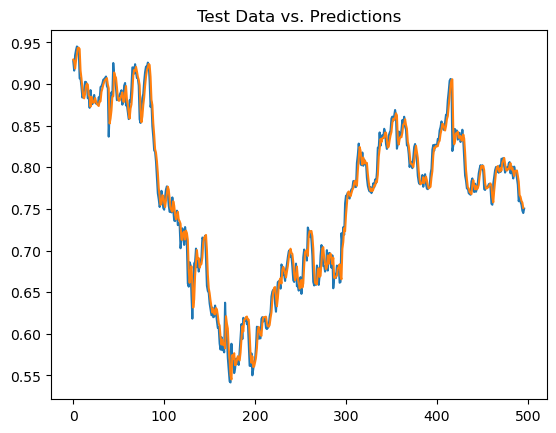

In [37]:
plt.plot(test_data[7:len(X)-(7+1)])
plt.plot(y_preds)
plt.title('Test Data vs. Predictions')

## Future Predictions of best model

In [38]:
import datetime

def future_prediction(data, days=30):
    model_inputs = data[-1]
    predictions = []
    
    for i in range(days):
        y_pred = model1.predict(tf.expand_dims(model_inputs, axis=0))
        model_inputs[:, :-1] = model_inputs[:, 1:]
        model_inputs[:, -1] = y_pred
        y_pred = tf.squeeze(scaler.inverse_transform(y_pred))
        predictions.append(y_pred)
    
    predictions = np.array(predictions)
    return predictions       

In [39]:
predictions = future_prediction(X_test, 30)

1/1 [==============================] - 0s 26ms/step


In [40]:
# making a date array (required when plotting)
today = np.datetime64(datetime.date.today())
date_array = today + np.arange(30)

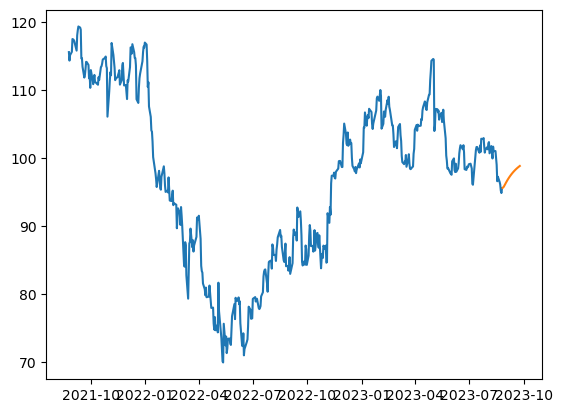

In [41]:
plt.plot(df['Date'][int(len(X_scaled)*0.9):], tf.squeeze(scaler.inverse_transform(test_data)))
plt.plot(date_array, predictions)

In [43]:
predictions

array([95.58052 , 95.6824  , 95.74732 , 95.92505 , 96.07552 , 96.246376,
       96.40531 , 96.55788 , 96.70912 , 96.85296 , 96.99174 , 97.12508 ,
       97.25309 , 97.37623 , 97.49451 , 97.608215, 97.71755 , 97.82271 ,
       97.92386 , 98.0212  , 98.11489 , 98.20508 , 98.29191 , 98.375534,
       98.45609 , 98.5337  , 98.60846 , 98.6805  , 98.74989 , 98.81679 ],
      dtype=float32)

## Saving the model

In [44]:
model1.save('Starbucks_lstm_model.h5')